# RF regression on sequence features with post‑hoc calibration
Minimal, readable pipeline split into cells.

## 1) Imports & config

In [71]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    from scipy.interpolate import PchipInterpolator
    _HAVE_PCHIP = True
except Exception:
    _HAVE_PCHIP = False

INFILE = "merged_output_balanced_2.csv"   # must contain columns: sequence, LogGFP
SEQ_COL = "sequence"
LABEL_COL = "LogGFP"
WINDOW = ("central", 6, 24)                  # ("all",0,0) or ("span", start, end)
TEST_SIZE = 0.20
SEED = 123
OUT = "seq_rf"

RF_PARAMS = dict(
    n_estimators=1000,
    max_depth=None,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
)


The in R studion done 4 feature were computed an used for the training.

In [72]:
# ---- shape feature builder: returns X (DataFrame) ----
import re
import numpy as np
import pandas as pd

FAMILIES    = ["MGW", "ProT", "Roll","HelT"]   # edit if needed
KEEP_WINDOW = (6, 24)                   # inclusive positions
EXCLUDE_IF_CONTAINS = ("rep",)          # optional substring filter

def build_X_feature(df: pd.DataFrame,
            families=FAMILIES,
            keep_window=KEEP_WINDOW,
            exclude_contains=EXCLUDE_IF_CONTAINS) -> pd.DataFrame:
    """Select MGW/ProT/Roll columns with trailing _pos index in [6..24] and return numeric DataFrame."""
    start_idx, end_idx = keep_window
    cols = []
    for c in df.columns:
        base = c.split("_")[0] if "_" in c else None
        if base not in families:
            continue
        m = re.search(r"_(\d+)$", c)
        if not m:
            continue
        pos = int(m.group(1))
        if not (start_idx <= pos <= end_idx):
            continue
        if exclude_contains and any(s in c for s in exclude_contains):
            continue
        cols.append(c)
    # numeric df (no imputation/variance here)
    return df[cols].apply(pd.to_numeric, errors="coerce")



2) Split → train-only filtering + imputation

In [73]:
from sklearn.model_selection import KFold
from sklearn.isotonic import IsotonicRegression

# 1) Load & filter
df = pd.read_csv(INFILE)


X = build_X_feature(df)
y = pd.to_numeric(df[LABEL_COL], errors="coerce").to_numpy()


# 80/20 with finer stratification
bins = pd.qcut(pd.Series(y), q=30, labels=False, duplicates="drop")
Xtr, Xte, ytr, yte = train_test_split(
    X, y, train_size=0.80, test_size=0.20,
    random_state=SEED, stratify=bins
)



# drop near-constant features using TRAIN ONLY
var_mask = Xtr.var(ddof=0) > 1e-12
Xtr = Xtr.loc[:, var_mask]
Xte = Xte.loc[:, var_mask.index[var_mask]]

# impute using TRAIN ONLY
imp = SimpleImputer(strategy="mean")
Xtr = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xte = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)


3) Weights + fit (asymmetric tails)

In [74]:
def band_weights_5(y, qcuts=(0.15, 0.35, 0.60, 0.85),
                   w=(10.0, 4.0, 1.0, 4.0, 10.0),
                   normalize=True):
    y = np.asarray(y, float)
    q1, q2, q3, q4 = np.quantile(y, qcuts)

    wv = np.full_like(y, w[2], dtype=float)       # middle band
    wv[y <= q1] = w[0]                            # very low
    wv[(y > q1) & (y <= q2)] = w[1]               # low
    wv[(y > q2) & (y <= q3)] = w[2]               # mid
    wv[(y > q3) & (y <= q4)] = w[3]               # high
    wv[y > q4] = w[4]                             # very high

    if normalize and wv.mean() > 0:
        wv /= wv.mean()
    return wv


## 4) Train, calibrate, evaluate

In [75]:
# ---------- drop-in: clean split + weights + no-leak calibration ----------

from sklearn.model_selection import train_test_split, KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.impute import SimpleImputer
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1) Load & filter
df = pd.read_csv(INFILE)
#df = pd.read_csv("merged_output_balanced.csv")
df = df[df[LABEL_COL] > 1.2].reset_index(drop=True)

# 2) Features (ensure build_X does NOT impute; we impute AFTER the split)
X = build_X_feature(df)
y = pd.to_numeric(df[LABEL_COL], errors="coerce").to_numpy()

# 3) Make 20-bin quantile strata (safe fallback if qcut errors)
def make_strata(y, Q=20):
    for q in range(Q, 5, -1):  # try 20 down to 6
        try:
            return pd.qcut(pd.Series(y), q=q, labels=False, duplicates="drop")
        except Exception:
            continue
    return None

bins = make_strata(y, Q=20)

# 4) 80/20 split (stratified if bins worked)
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED,
    stratify=bins if bins is not None else None
)

# 5) Train-only variance filter + imputer (prevents leakage)
var_mask = Xtr.var(ddof=0) > 1e-12
Xtr = Xtr.loc[:, var_mask]
Xte = Xte.loc[:, var_mask.index[var_mask]]

imp = SimpleImputer(strategy="mean")
Xtr = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xte = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)



rf_unw = RandomForestRegressor(random_state=SEED, n_jobs=-1, **RF_PARAMS).fit(Xtr, ytr)
rf_w   = RandomForestRegressor(random_state=SEED, n_jobs=-1, **RF_PARAMS).fit(Xtr, ytr, sample_weight=wtr)

print("Train R² unweighted:", r2_score(ytr, rf_unw.predict(Xtr)))
print("Train R² weighted:",   r2_score(ytr, rf_w.predict(Xtr)))

rf = rf_w  # <<< added: choose the model you want to use below (or rf_unw)

#




Train R² unweighted: 0.9367701384073591
Train R² weighted: 0.9343121074882743


callibration

In [87]:
# 8) Predictions
yhat_tr  = rf.predict(Xtr)
yhat_raw = rf.predict(Xte)

# 9) No-leak calibrator: OOF isotonic on train predictions
import numpy as np
from sklearn.model_selection import KFold
from sklearn.isotonic import IsotonicRegression

def fit_calibrator_oof_pred(y_pred_train, y_train, n_splits=5, seed=123):
    """
    Fit isotonic regression on TRAIN ONLY using K-fold OOF predictions
    and return a ('iso', fitted_model) tuple suitable for saving.
    """
    y_pred_train = np.asarray(y_pred_train, float)
    y_train      = np.asarray(y_train, float)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.empty_like(y_train, float)

    for tr, va in kf.split(y_pred_train):
        iso_k = IsotonicRegression(increasing=True, out_of_bounds="clip")
        iso_k.fit(y_pred_train[tr], y_train[tr])
        oof[va] = iso_k.predict(y_pred_train[va])

    # final calibrator refit on *all* train data
    iso = IsotonicRegression(increasing=True, out_of_bounds="clip")
    iso.fit(y_pred_train, y_train)
    return ("iso", iso)

def apply_calibrator(y_pred, calibrator):
    """
    Apply a saved calibrator tuple to predictions.
    Supports ('iso', model) and ('qmap', {'xp':..., 'fp':...}).
    """
    kind, obj = calibrator
    y_pred = np.asarray(y_pred, float)
    if kind == "iso":
        return obj.predict(y_pred)
    elif kind == "qmap":
        return np.interp(y_pred, obj["xp"], obj["fp"])
    else:
        return y_pred  # no-op fallback


# 10) Metrics
# Ensure we have test preds in `yhat`
if 'yhat' not in locals():
    if 'yhat_te' in locals():
        yhat = yhat_te
    else:
        # fall back: compute now
        s_te = rf.predict(Xte)
        try:
            yhat = apply_calibrator(s_te, calib)  # if you use calibration
        except Exception:
            yhat = s_te

assert 'yte' in locals(), "yte not defined"
assert len(yhat) == len(yte), "Pred/true length mismatch"

r2   = r2_score(yte, yhat)
rmse = mean_squared_error(yte, yhat) ** 0.5
mae  = mean_absolute_error(yte, yhat)
print(f"R²={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

R²=0.861 | RMSE=0.124 | MAE=0.089


## 5) Plots & saving predictions

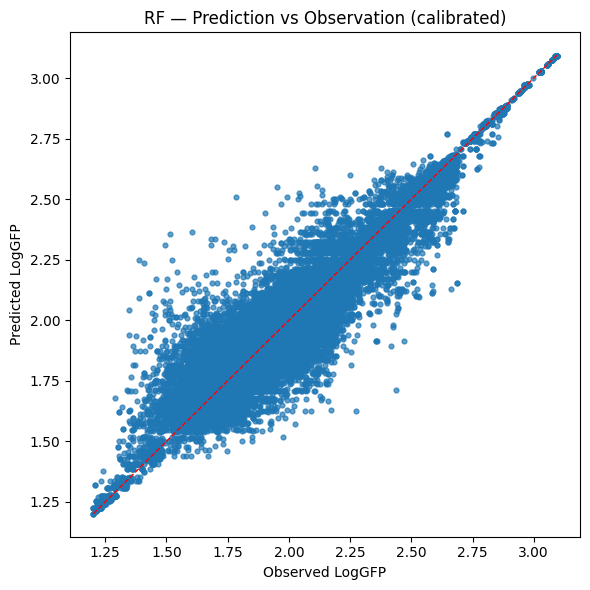

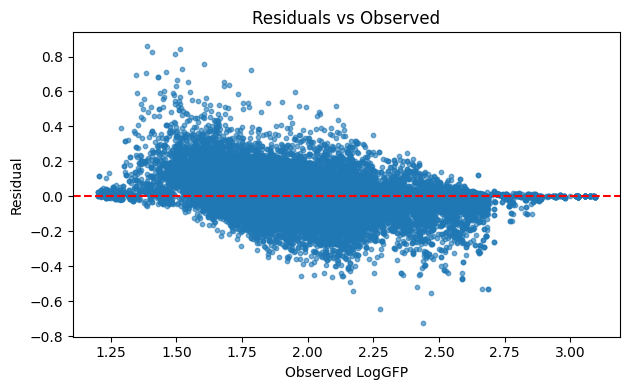

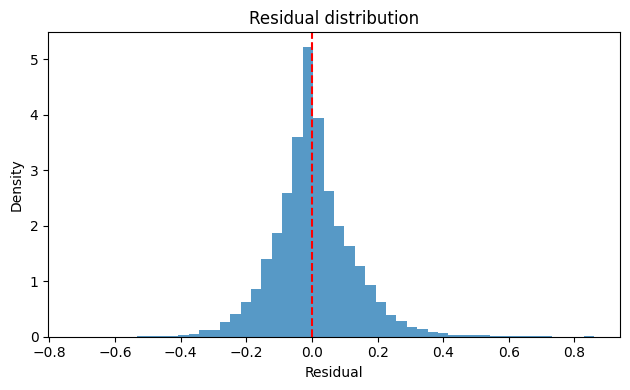

In [88]:
def show_and_save(fig, name):
    fig.tight_layout(); fig.savefig(f"{OUT}_{name}.png", dpi=300); plt.show(); plt.close(fig)

fig = plt.figure(figsize=(6,6))
plt.scatter(yte, yhat, s=12, alpha=0.7)
lo,hi = float(min(yte.min(),yhat.min())), float(max(yte.max(),yhat.max()))
plt.plot([lo,hi],[lo,hi],'r--',lw=1)
plt.xlabel("Observed LogGFP"); plt.ylabel("Predicted LogGFP")
plt.title("RF — Prediction vs Observation (calibrated)")
show_and_save(fig, "pred_vs_obs")

res = yhat - yte
fig = plt.figure(figsize=(6.4,4))
plt.scatter(yte,res,s=10,alpha=0.6); plt.axhline(0, color='r', ls='--')
plt.xlabel("Observed LogGFP"); plt.ylabel("Residual")
plt.title("Residuals vs Observed")
show_and_save(fig, "residuals_vs_obs")

fig = plt.figure(figsize=(6.4,4))
plt.hist(res, bins=50, density=True, alpha=0.75)
plt.axvline(0, color='r', ls='--'); plt.xlabel("Residual"); plt.ylabel("Density")
plt.title("Residual distribution")
show_and_save(fig, "residual_hist")

pd.DataFrame({"y_true":yte, "y_pred_raw":yhat_raw, "y_pred":yhat}).to_csv(f"{OUT}_preds.csv", index=False)


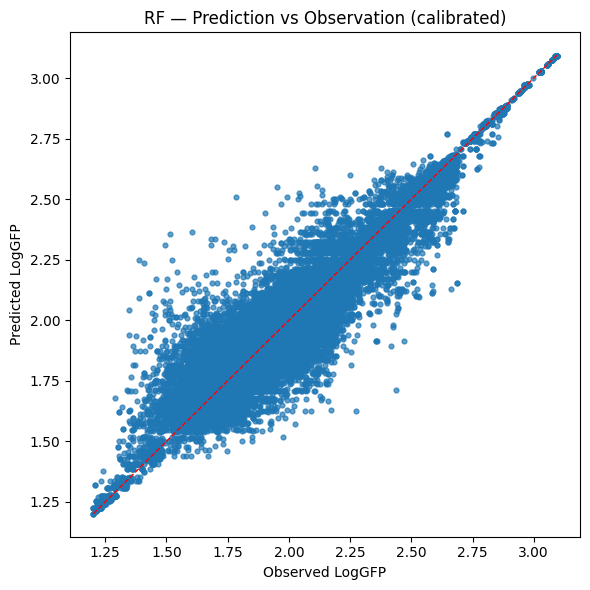

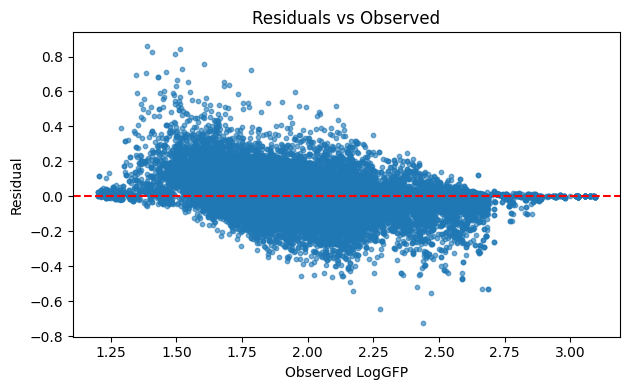

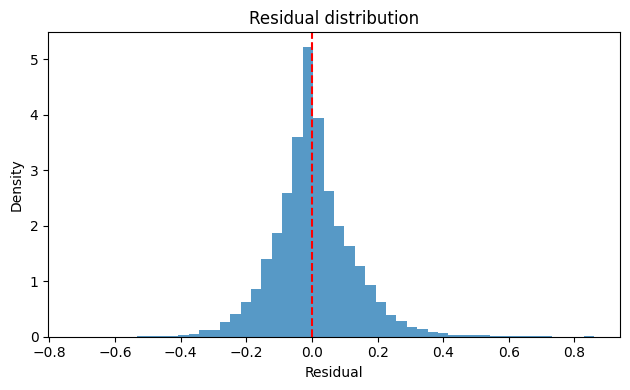

In [78]:
def show_and_save(fig, name):
    fig.tight_layout(); fig.savefig(f"{OUT}_{name}.png", dpi=300); plt.show(); plt.close(fig)

fig = plt.figure(figsize=(6,6))
plt.scatter(yte, yhat, s=12, alpha=0.7)
lo,hi = float(min(yte.min(),yhat.min())), float(max(yte.max(),yhat.max()))
plt.plot([lo,hi],[lo,hi],'r--',lw=1)
plt.xlabel("Observed LogGFP"); plt.ylabel("Predicted LogGFP")
plt.title("RF — Prediction vs Observation (calibrated)")
show_and_save(fig, "pred_vs_obs")

res = yhat - yte
fig = plt.figure(figsize=(6.4,4))
plt.scatter(yte,res,s=10,alpha=0.6); plt.axhline(0, color='r', ls='--')
plt.xlabel("Observed LogGFP"); plt.ylabel("Residual")
plt.title("Residuals vs Observed")
show_and_save(fig, "residuals_vs_obs")

fig = plt.figure(figsize=(6.4,4))
plt.hist(res, bins=50, density=True, alpha=0.75)
plt.axvline(0, color='r', ls='--'); plt.xlabel("Residual"); plt.ylabel("Density")
plt.title("Residual distribution")
show_and_save(fig, "residual_hist")

pd.DataFrame({"y_true":yte, "y_pred_raw":yhat_raw, "y_pred":yhat}).to_csv(f"{OUT}_preds.csv", index=False)


In [79]:
print(f"Train R² = {r2_score(ytr, yhat_tr):.3f}")
print(f"Test  R² = {r2_score(yte, yhat):.3f}")


Train R² = 0.934
Test  R² = 0.861


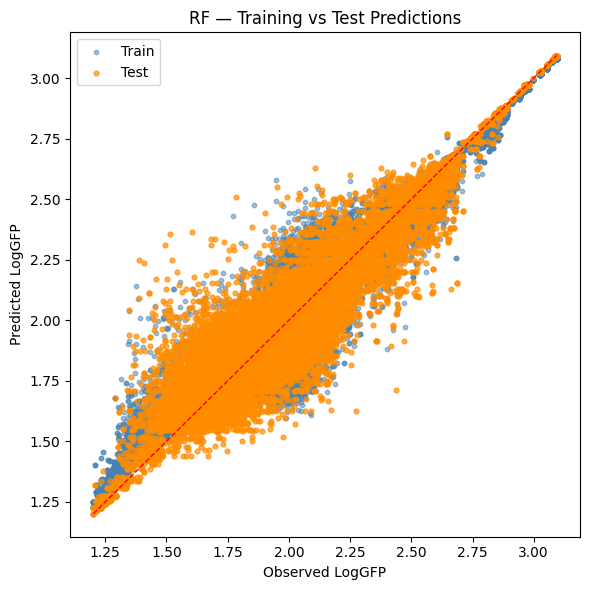

In [80]:
# --- Training vs Test prediction comparison ---
fig = plt.figure(figsize=(6,6))

# Training set (blue)
plt.scatter(ytr, yhat_tr, s=10, alpha=0.5, label="Train", color="steelblue")

# Test set (orange)
plt.scatter(yte, yhat, s=12, alpha=0.7, label="Test", color="darkorange")

# Identity line
lo, hi = float(min(y.min() for y in [ytr, yte, yhat_tr, yhat])), float(max(y.max() for y in [ytr, yte, yhat_tr, yhat]))
plt.plot([lo, hi], [lo, hi], "r--", lw=1)

plt.xlabel("Observed LogGFP")
plt.ylabel("Predicted LogGFP")
plt.title("RF — Training vs Test Predictions")
plt.legend()
show_and_save(fig, "train_vs_test")


Blue points (Train): predictions on your training data (ytr vs yhat_tr)
Orange points (Test): predictions on your held-out test data (yte vs yhat)
Red dashed line: ideal line where Predicted = Observed

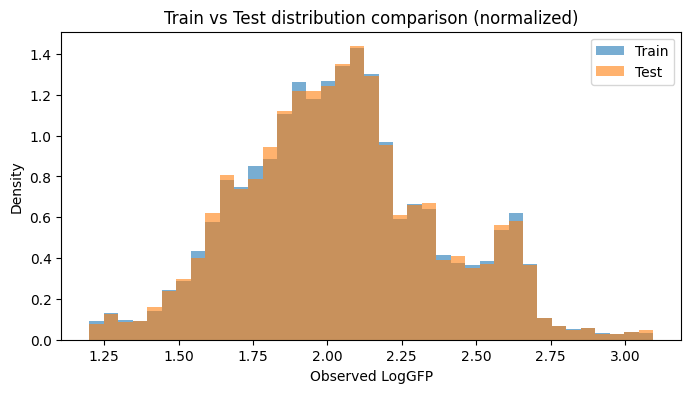

In [81]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(y.min(), y.max(), 40)  # same bins for both

plt.figure(figsize=(8, 4))
plt.hist(ytr, bins=bins, density=True, alpha=0.6, label="Train")
plt.hist(yte, bins=bins, density=True, alpha=0.6, label="Test")
plt.xlabel("Observed LogGFP")
plt.ylabel("Density")
plt.title("Train vs Test distribution comparison (normalized)")
plt.legend()
plt.show()


see the distribution

78324 19582 4.0
Middle counts 1.90–2.00: train= 9591 test= 2388


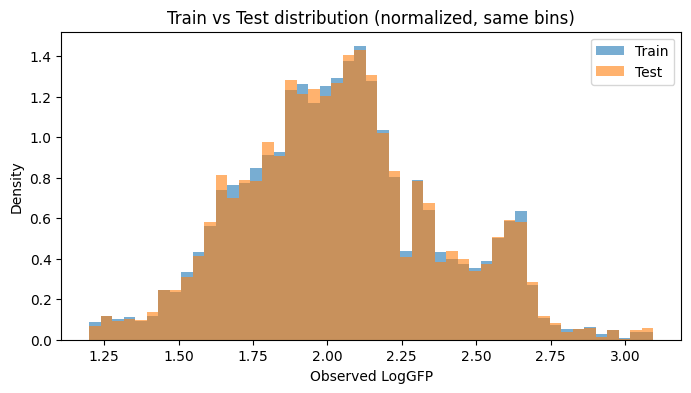

Train quantiles:
 0.0    1.201
0.1    1.636
0.2    1.763
0.3    1.868
0.4    1.949
0.5    2.031
0.6    2.104
0.7    2.180
0.8    2.318
0.9    2.545
1.0    3.094
dtype: float64

Test quantiles:
 0.0    1.201
0.1    1.636
0.2    1.763
0.3    1.868
0.4    1.949
0.5    2.031
0.6    2.104
0.7    2.180
0.8    2.318
0.9    2.545
1.0    3.094
dtype: float64


In [82]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Confirm sizes (should be ~80/20)
print(len(ytr), len(yte), round(len(ytr)/len(yte), 3))

# 2) Count samples in the “middle” band, e.g. 1.90–2.00
mid_mask_tr = (ytr >= 1.90) & (ytr <= 2.00)
mid_mask_te = (yte >= 1.90) & (yte <= 2.00)
print("Middle counts 1.90–2.00:",
      "train=", mid_mask_tr.sum(),
      "test=",  mid_mask_te.sum())

# 3) Compare shapes with SAME bins and density (so areas match)
bins = np.linspace(y.min(), y.max(), 50)
plt.figure(figsize=(8,4))
plt.hist(ytr, bins=bins, density=True, alpha=0.6, label="Train")
plt.hist(yte, bins=bins, density=True, alpha=0.6, label="Test")
plt.xlabel("Observed LogGFP"); plt.ylabel("Density")
plt.title("Train vs Test distribution (normalized, same bins)")
plt.legend(); plt.show()

# 4) Quantile table to see coverage across the range
qs = np.linspace(0,1,11)
print("Train quantiles:\n", pd.Series(ytr).quantile(qs).round(3))
print("\nTest quantiles:\n",  pd.Series(yte).quantile(qs).round(3))


the saved model

In [83]:
import joblib, json, time

CALIBRATOR = calib  # <-- use the tuple returned above

bundle = {
    "version": "shape_rf_v1",
    "trained_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "label_col": LABEL_COL,
    "families": FAMILIES,
    "keep_window": KEEP_WINDOW,
    "exclude": EXCLUDE_IF_CONTAINS,
    "rf_params": getattr(rf, "get_params", lambda: {})(),
    "seed": SEED,

    "feature_columns": list(Xtr.columns),
    "imputer": imp,
    "calibrator": CALIBRATOR,

    "model": rf,
}

joblib.dump(bundle, "shape_rf_model.joblib")
print("Saved: shape_rf_model.joblib")

# (optional) metadata
meta = {k: (v if isinstance(v, (str,int,float,bool,tuple,list,dict)) else str(type(v)))
        for k,v in bundle.items() if k not in ["imputer","model","calibrator"]}
with open("shape_rf_model.meta.json","w") as f:
    json.dump(meta, f, indent=2)
print("Saved: shape_rf_model.meta.json")


Saved: shape_rf_model.joblib
Saved: shape_rf_model.meta.json


the prediction on new sequnces not seen by the model

In [84]:
import re, numpy as np, pandas as pd, joblib

# ===== Config =====
MODEL_PATH = "shape_rf_model.joblib"
NEW_FILE   = "Up_library_features_unseen.csv"   # your unseen FEATURES (not sequences)
OUT_FILE   = "predictionsno_calibrated_feature.tsv"

# ===== Load bundle =====
B   = joblib.load(MODEL_PATH)
rf  = B["model"]
imp = B.get("imputer", None)
feat_cols = B["feature_columns"]               # columns the model expects
var_mask  = B.get("var_mask", None)            # optional, if you saved it

# Calibrator (None | ("iso", model) | {"xp","fp"})
cal = B.get("calibrator", None)
if cal is None:
    calib_name, calib_obj = None, None
elif isinstance(cal, tuple) and len(cal) == 2:
    calib_name, calib_obj = cal
elif isinstance(cal, dict) and {"xp","fp"} <= set(cal.keys()):
    calib_name, calib_obj = "qmap", cal
else:
    raise ValueError(f"Unrecognized calibrator: {type(cal)}")

# ===== Load new feature table =====
# Auto-detect delimiter (csv/tsv)
new_raw = pd.read_csv(NEW_FILE, sep=None, engine="python")

# Optional: standardize shape column names to match training
SHAPES = ("MGW","ProT","Roll","HelT")
pat = re.compile(rf"^({'|'.join(map(re.escape, SHAPES))})[._]?(\d+)$")
def std_name(c):
    m = pat.match(str(c))
    if m:
        shape, idx = m.group(1), int(m.group(2))
        return f"{shape}_{idx:02d}"
    return c

new = new_raw.rename(columns={c: std_name(c) for c in new_raw.columns})

# If you saved a variance mask during training, apply it now (keeps only trained features)
if var_mask is not None:
    keep_cols = list(var_mask.index[var_mask])
else:
    keep_cols = feat_cols

# Align to training feature order
missing = [c for c in keep_cols if c not in new.columns]
if missing:
    raise ValueError("Missing required features (first 20 shown): " + ", ".join(missing[:20]))

Xnew = new.reindex(columns=keep_cols).apply(pd.to_numeric, errors="coerce")

# Impute with training imputer if present
if imp is not None:
    Xnew = pd.DataFrame(imp.transform(Xnew), columns=keep_cols, index=new.index)

# Predict
y_raw = rf.predict(Xnew).astype(float)

# Calibrate (if available)
if calib_name == "iso" and calib_obj is not None:
    y_pred = calib_obj.predict(y_raw)
elif calib_name == "qmap" and calib_obj is not None:
    xp, fp = calib_obj["xp"], calib_obj["fp"]
    y_pred = np.interp(y_raw, xp, fp)
else:
    y_pred = y_raw

# ===== Save: keep id/sequence if present =====
cols_to_keep = [c for c in ["seq_id", "sequence"] if c in new.columns]
out = pd.DataFrame({"prediction": y_pred}, index=new.index)
for c in reversed(cols_to_keep):
    out.insert(0, c, new[c].values)

out.to_csv(OUT_FILE, sep="\t", index=False)
print(f"Saved: {OUT_FILE}  rows={len(out)}")


Saved: predictionsno_calibrated_feature.tsv  rows=10000


In [85]:
# 3) Get top 3 strongest predictions overall
top3 = out.sort_values("prediction", ascending=False).head(3)
top3["core19"] = top3["sequence"].str.slice(4, -4)  # trim flanks
top3.to_csv("predictions_top3_4.tsv", sep="\t", index=False)

# 4) Get bottom 3 weakest predictions overall
bottom3 = out.sort_values("prediction", ascending=True).head(3)
bottom3["core19"] = bottom3["sequence"].str.slice(4, -4)  # trim flanks
bottom3.to_csv("predictions_bottom3_4.tsv", sep="\t", index=False)

print("Also wrote:")
print(" - predictions_binned_sample3_4.tsv  (3 per bin)")
print(" - predictions_top3_4.tsv            (strongest 3 overall)")
print(" - predictions_bottom3_4.tsv         (weakest 3 overall)")


Also wrote:
 - predictions_binned_sample3_4.tsv  (3 per bin)
 - predictions_top3_4.tsv            (strongest 3 overall)
 - predictions_bottom3_4.tsv         (weakest 3 overall)


look for any sequnce in there

In [86]:
import pandas as pd

# Read as tab-separated
df = pd.read_csv("predictionsno_calibrated_feature.tsv", sep="\t")

def lookup(seq):
    print(df.loc[df["sequence"] == seq, ["sequence", "prediction"]])

lookup("AAGGCTATATGCGGTACAGGCCTGCTT")


                         sequence  prediction
5879  AAGGCTATATGCGGTACAGGCCTGCTT    1.456968
